# Step #1: Explore and prep data

In [40]:
import pandas as pd
import sqlalchemy
import pandas_ta
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.metrics import confusion_matrix

def ticker_preprocess(result_set) -> pd.DataFrame:
    result_set.ta.vwma(close='Adj Close', append=True, length=5)
    result_set.ta.vwma(close='Adj Close', append=True, length=20)
    result_set.ta.vwma(close='Adj Close', append=True, length=90)
    result_set.ta.mfi(close='Adj Close', append=True)
    result_set.ta.macd(append=True)
    result_set.ta.rsi(append=True)
    result_set.ta.bbands(append=True)
    result_set.ta.obv(append=True)
    result_set.ta.sma(length=20, append=True)
    result_set.ta.ema(length=50, append=True)
    result_set.ta.stoch(append=True)
    result_set.ta.adx(append=True)
    result_set.ta.ad(append=True)
    result_set.ta.stdev(append=True)
    
    result_set.reset_index(inplace=True)

    
    result_set['Volume_5'] = result_set['Volume'].rolling(5).mean()
    result_set['Volume_20'] = result_set['Volume'].rolling(20).mean()
    result_set['Volume_90'] = result_set['Volume'].rolling(90).mean()

    result_set['delta_p5'] = result_set['Adj Close'] - result_set['VWMA_5']
    result_set['delta_p20'] = result_set['Adj Close'] - result_set['VWMA_20']
    result_set['delta_p90'] = result_set['Adj Close'] - result_set['VWMA_90']

    result_set['delta_v5'] = result_set['Volume'] - result_set['Volume_5']
    result_set['delta_v20'] = result_set['Volume'] - result_set['Volume_20']
    result_set['delta_v90'] = result_set['Volume'] - result_set['Volume_90']
    
    result_set['PV_DELTA_R5'] = result_set['delta_p5'] /result_set['delta_v5'] 
    result_set['PV_DELTA_R20'] = result_set['delta_p20'] /result_set['delta_v20'] 
    result_set['PV_DELTA_R90'] = result_set['delta_p90'] /result_set['delta_v90'] 

    result_set['PV_DELTA_R20_PRIOR1'] = result_set['PV_DELTA_R20'].shift(1)
    result_set['PV_DELTA_R20_PRIOR2'] = result_set['PV_DELTA_R20'].shift(2)
    result_set['PV_DELTA_R20_PRIOR3'] = result_set['PV_DELTA_R20'].shift(3)
    result_set['PV_DELTA_R20_PRIOR4'] = result_set['PV_DELTA_R20'].shift(4)
    result_set['PV_DELTA_R20_PRIOR5'] = result_set['PV_DELTA_R20'].shift(5)
    result_set['target'] = (result_set['Y_CLOSE5_MIN'] - result_set['Adj Close'] ) / result_set['Adj Close'] * 100 < 5

    return result_set

# please use the dataset bank-additional.zip and extract it
query = '''
select DISTINCT S.date,Open ,High ,Low ,Close ,"Adj Close" ,Volume ,MACD_12_26_9 ,MACDh_12_26_9 ,MACDs_12_26_9 ,RSI_14 ,"BBL_5_2.0" ,
"BBM_5_2.0" ,"BBU_5_2.0" ,"BBB_5_2.0" ,"BBP_5_2.0" ,OBV ,SMA_20 ,EMA_50 ,STOCHk_14_3_3 ,STOCHd_14_3_3 ,ADX_14 ,DMP_14 ,DMN_14 ,AD ,
STDEV_30  ,Y_CLOSE5_MIN,ticker,BULLISH,BEARISH, TEMPERATURE_AVG,PRESSURE_AVG
 from STOCK_DAILY S
 INNER JOIN AAII_SENTIMENT A ON (date(A.DATE) BETWEEN date(S.DATE, '-7 days') AND date(S.DATE)) 
 INNER JOIN NY_WEATHER NY WHERE NY.DATE = S.DATE
'''
sqlengine = sqlalchemy.create_engine('sqlite:///D:\\sqlite\\data\\finance.db')
result_set = pd.read_sql_query(query, sqlengine.connect())
grouped = result_set.groupby(['ticker'])
finalResult = pd.DataFrame()
for name, group in grouped:
    # group.reset_index()
    # group.set_index('Date',inplace=True)
    group = ticker_preprocess(group)
    finalResult = pd.concat([group,finalResult])

cols_to_drop = ['Date','Open','High','Low','Close','ticker','VWMA_5','VWMA_20','VWMA_90','Y_CLOSE5_MIN']
df = finalResult.drop(columns=cols_to_drop).dropna()
df.head()

,Adj Close,Volume,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,RSI_14,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,...,PV_DELTA_R20,PV_DELTA_R90,PV_DELTA_R20_PRIOR1,PV_DELTA_R20_PRIOR2,PV_DELTA_R20_PRIOR3,PV_DELTA_R20_PRIOR4,PV_DELTA_R20_PRIOR5,PRESSURE_FORECAST,TEMPERATURE_FORECAST,target
9287,-1.232434,-0.787892,1.162296,0.687160,1.003326,1.157978,-1.130241,-1.116272,-1.079098,0.285892,...,0.009219,-0.220861,0.041963,0.046884,0.047213,0.028154,0.081252,30.34,44.16,True
9288,-1.413282,-0.751758,1.130056,0.477658,1.050949,0.633077,-0.937785,-1.061502,-1.159377,-0.743782,...,0.027477,-0.208072,0.009265,0.041989,0.046901,0.047220,0.028210,30.32,45.76,True
9289,-1.538781,-1.023692,1.024589,0.148234,1.066008,0.294214,-1.018901,-1.090867,-1.137798,-0.356836,...,0.051616,-0.084847,0.027514,0.009306,0.042008,0.046908,0.047266,30.30,47.96,True
9290,-1.299365,-1.298096,1.056677,0.188676,1.085065,0.800063,-0.976608,-1.053034,-1.105100,-0.394881,...,0.043102,-0.074946,0.051641,0.027546,0.009342,0.042017,0.046954,30.26,49.86,True
9291,-1.299365,-1.298096,1.056677,0.188676,1.085065,0.800063,-0.976608,-1.053034,-1.105100,-0.394881,...,0.044033,-0.074273,0.043131,0.051662,0.027573,0.009367,0.042066,30.16,53.00,True


In [41]:
# # list and drop columns that are less related to the target based on my judgment
# cols_to_drop = ['Date']
# # at the same time, rename the columns so they are understandable. Please read the UCI page (https://archive.ics.uci.edu/ml/datasets/bank+marketing) for details
# finalResult = finalResult.drop(columns=cols_to_drop).dropna()
# # convert the target to numerical values
df['target'] = df['target'].replace({True: 1, False: 0})

In [42]:
df.head()

,Adj Close,Volume,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,RSI_14,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,...,PV_DELTA_R20,PV_DELTA_R90,PV_DELTA_R20_PRIOR1,PV_DELTA_R20_PRIOR2,PV_DELTA_R20_PRIOR3,PV_DELTA_R20_PRIOR4,PV_DELTA_R20_PRIOR5,PRESSURE_FORECAST,TEMPERATURE_FORECAST,target
9287,-1.232434,-0.787892,1.162296,0.687160,1.003326,1.157978,-1.130241,-1.116272,-1.079098,0.285892,...,0.009219,-0.220861,0.041963,0.046884,0.047213,0.028154,0.081252,30.34,44.16,1
9288,-1.413282,-0.751758,1.130056,0.477658,1.050949,0.633077,-0.937785,-1.061502,-1.159377,-0.743782,...,0.027477,-0.208072,0.009265,0.041989,0.046901,0.047220,0.028210,30.32,45.76,1
9289,-1.538781,-1.023692,1.024589,0.148234,1.066008,0.294214,-1.018901,-1.090867,-1.137798,-0.356836,...,0.051616,-0.084847,0.027514,0.009306,0.042008,0.046908,0.047266,30.30,47.96,1
9290,-1.299365,-1.298096,1.056677,0.188676,1.085065,0.800063,-0.976608,-1.053034,-1.105100,-0.394881,...,0.043102,-0.074946,0.051641,0.027546,0.009342,0.042017,0.046954,30.26,49.86,1
9291,-1.299365,-1.298096,1.056677,0.188676,1.085065,0.800063,-0.976608,-1.053034,-1.105100,-0.394881,...,0.044033,-0.074273,0.043131,0.051662,0.027573,0.009367,0.042066,30.16,53.00,1


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9280 entries, 9287 to 2038
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Adj Close             9280 non-null   float64
 1   Volume                9280 non-null   float64
 2   MACD_12_26_9          9280 non-null   float64
 3   MACDh_12_26_9         9280 non-null   float64
 4   MACDs_12_26_9         9280 non-null   float64
 5   RSI_14                9280 non-null   float64
 6   BBL_5_2.0             9280 non-null   float64
 7   BBM_5_2.0             9280 non-null   float64
 8   BBU_5_2.0             9280 non-null   float64
 9   BBB_5_2.0             9280 non-null   float64
 10  BBP_5_2.0             9280 non-null   float64
 11  OBV                   9280 non-null   float64
 12  SMA_20                9280 non-null   float64
 13  EMA_50                9280 non-null   float64
 14  STOCHk_14_3_3         9280 non-null   float64
 15  STOCHd_14_3_3         9

In [44]:
df['target'].value_counts()

target
1    9175
0     105
Name: count, dtype: int64

In [45]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='target')
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=8)

# Step #2: Build a pipeline of training

In [46]:
# !pip install xgboost
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier

xgbModel = XGBClassifier(random_state=8, scale_pos_weight=9)

estimators = [
    ('encoder', TargetEncoder()),
    ('clf', xgbModel) # can customize objective function with the objective parameter
]
pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('encoder', TargetEncoder()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=8, ...))])

# Step #3: Set up hyperparameter tuning

In [47]:
# !pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

opt = BayesSearchCV(pipe, search_space, cv=5, n_iter=20, scoring='roc_auc', random_state=8) 
# in reality, you may consider setting cv and n_iter to higher values

# Step #4: Train the XGBoost model

In [48]:
import numpy as np
np.int = int
opt.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('encoder', TargetEncoder()),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type=N...
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

# Step #5: Evaluate the model and make predictions

In [49]:
opt.best_estimator_

Pipeline(steps=[('encoder', TargetEncoder(cols=[])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=1.0, colsample_bynode=1.0,
                               colsample_bytree=0.5, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=1.0,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=8, ...))])

In [50]:
opt.best_score_

0.757721840439173

In [51]:
opt.score(X_test, y_test)

0.738121188529908

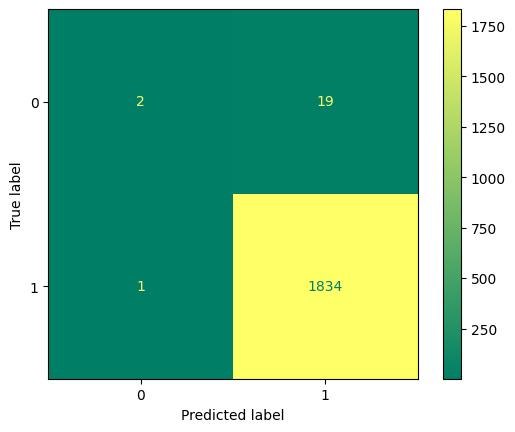

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay

y_predict = opt.predict(X_test)

 
cm = confusion_matrix(y_test,y_predict,labels=opt.best_estimator_.steps[1][1].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=opt.best_estimator_.steps[1][1].classes_);
disp.plot(cmap='summer')



In [17]:
opt.predict_proba(X_test)
# opt.best_estimator_.steps[1][1].save_model('./tamed/xgb_m1.1.json')


# Step #6: Measure feature importance (optional)

In [18]:
opt.best_estimator_.steps

[('encoder', TargetEncoder(cols=[])),
 ('clf',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=0.8288025602063678,
                colsample_bynode=0.9909238786806638, colsample_bytree=1.0,
                device=None, early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=0.0, grow_policy=None,
                importance_type=None, interaction_constraints=None,
                learning_rate=0.48773708887998735, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=8, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, random_state=8, ...))]

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

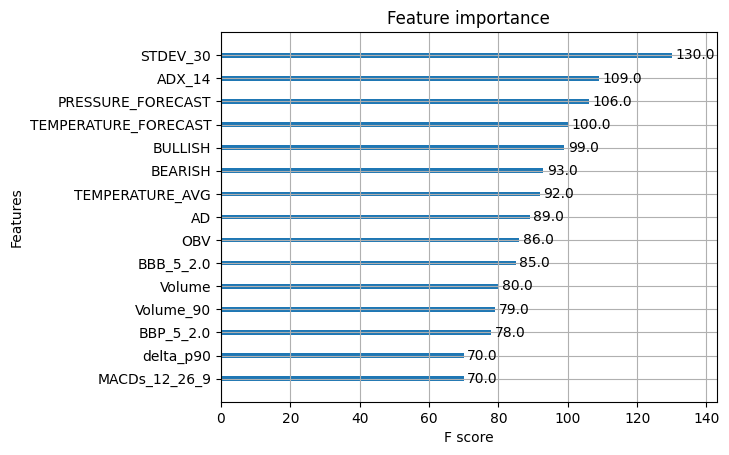

In [19]:
from xgboost import plot_importance

xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model,max_num_features=15)
